<a href="https://colab.research.google.com/github/ARKAL-J04/KNTU_AI_4032/blob/main/MP_3/AI_HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
!pip install scikit-fuzzy

import skfuzzy as fuzz
from skfuzzy import control as ctrl
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error
import seaborn as sns
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
#from anfis import AnfisNet
#from anfis.membership import make_tri_mfs


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 12.2 MB/s eta 0:00:00


#1

In [ ]:
# Install required libraries
!pip install -q scikit-fuzzy
!pip install -q torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.2 MB/s eta 0:00:00


In [ ]:
# Target function
def h(x):
    return np.exp(-np.pi * x**2) + x * np.sin(np.pi * x)

# Data
x_vals = np.linspace(-1, 1, 300).reshape(-1, 1).astype(np.float32)
y_vals = h(x_vals).reshape(-1, 1).astype(np.float32)  # Ensure correct shape

In [ ]:
#Mamdani Fuzzy System (Manual rules - No learning)
# Define fuzzy variables
x_fuzzy = ctrl.Antecedent(np.linspace(-1, 1, 100), 'x')
y_fuzzy = ctrl.Consequent(np.linspace(-0.2, 1.5, 100), 'y')

# Auto-membership functions (3 functions)
x_fuzzy.automf(3, names=['low', 'medium', 'high'])
y_fuzzy.automf(3, names=['low', 'medium', 'high'])

# Simple manual rules
rule1 = ctrl.Rule(x_fuzzy['low'], y_fuzzy['low'])
rule2 = ctrl.Rule(x_fuzzy['medium'], y_fuzzy['medium'])
rule3 = ctrl.Rule(x_fuzzy['high'], y_fuzzy['high'])

# Build control system
mamdani_system = ctrl.ControlSystem([rule1, rule2, rule3])
mamdani_sim = ctrl.ControlSystemSimulation(mamdani_system)

# Prediction
mamdani_outputs = []
for val in x_vals.flatten():
    try:
        mamdani_sim.input['x'] = val
        mamdani_sim.compute()
        mamdani_outputs.append(mamdani_sim.output['y'])
    except:
        mamdani_outputs.append(np.nan)  # Handle potential errors

mamdani_outputs = np.array(mamdani_outputs, dtype=np.float32).reshape(-1, 1)

In [ ]:
#(Gradient descent learning)
# Define a simple ANFIS-like model with PyTorch
class SimpleANFIS(nn.Module):
    def __init__(self, n_inputs=1, n_rules=3):
        super(SimpleANFIS, self).__init__()
        self.n_rules = n_rules
        # Membership function parameters (Gaussian)
        self.mu = nn.Parameter(torch.linspace(-1, 1, n_rules).reshape(1, n_rules))
        self.sigma = nn.Parameter(torch.ones(1, n_rules) * 0.2)
        # Output layer
        self.linear = nn.Linear(n_rules, 1)

    def forward(self, x):
        # Calculate Gaussian membership functions
        x = x.view(-1, 1)
        membership = torch.exp(-((x - self.mu) ** 2) / (2 * self.sigma ** 2))
        # Normalize
        weights = membership / (torch.sum(membership, dim=1, keepdim=True) + 1e-10)
        # Linear output
        out = self.linear(weights)
        return out

# Build model
model = SimpleANFIS(n_inputs=1, n_rules=3)

# Prepare data for PyTorch
x_tensor = torch.from_numpy(x_vals)
y_tensor = torch.from_numpy(y_vals)

# Train model with MSE and Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

losses = []
for epoch in range(300):
    optimizer.zero_grad()
    output = model(x_tensor)
    loss = loss_fn(output, y_tensor)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

# Trained model output
y_anfis_pred = model(x_tensor).detach().numpy()

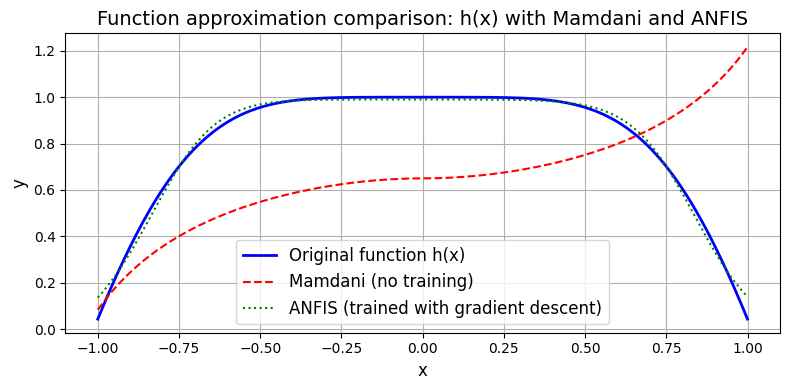

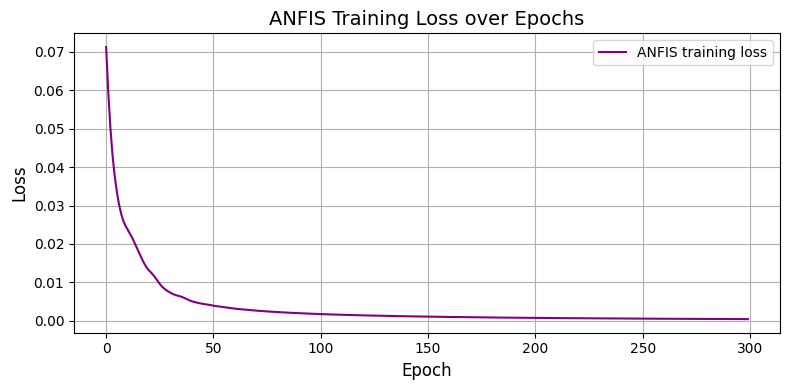

Mamdani System MSE: 0.1440
ANFIS System MSE: 0.0004


In [ ]:
# Comparison of Results
plt.figure(figsize=(8, 4))
plt.plot(x_vals.flatten(), y_vals.flatten(), label='Original function h(x)', linewidth=2, color='blue')
plt.plot(x_vals.flatten(), mamdani_outputs.flatten(), label='Mamdani (no training)', linestyle='--', color='red')
plt.plot(x_vals.flatten(), y_anfis_pred.flatten(), label='ANFIS (trained with gradient descent)', linestyle=':', color='green')
plt.legend(fontsize=12)
plt.grid(True)
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title('Function approximation comparison: h(x) with Mamdani and ANFIS', fontsize=14)
plt.tight_layout()
plt.show()

# Plot ANFIS training loss
plt.figure(figsize=(8, 4))
plt.plot(losses, color='purple', label='ANFIS training loss')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('ANFIS Training Loss over Epochs', fontsize=14)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Final error calculation
import numpy as np

# Remove NaN values from mamdani_outputs before computing MSE
valid_indices = ~np.isnan(mamdani_outputs.flatten())
filtered_y_vals = y_vals.flatten()[valid_indices]
filtered_mamdani_outputs = mamdani_outputs.flatten()[valid_indices]

mse_mamdani = mean_squared_error(filtered_y_vals, filtered_mamdani_outputs)
mse_anfis = mean_squared_error(y_vals.flatten(), y_anfis_pred.flatten())

print(f"Mamdani System MSE: {mse_mamdani:.4f}")
print(f"ANFIS System MSE: {mse_anfis:.4f}")

#2

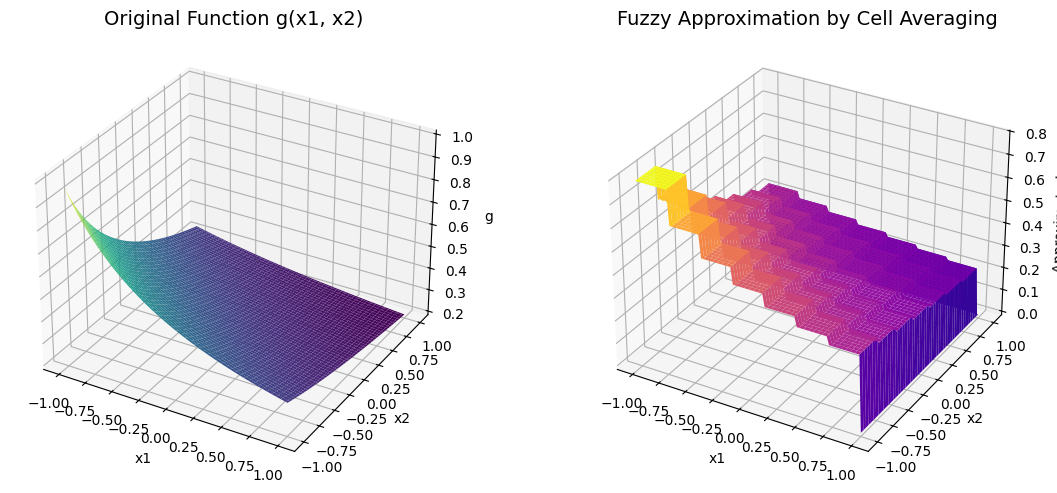

In [ ]:
# Define the original target function
def g(x1, x2):
    return 1 / (3 + x1 + x2)

# Define the domain U = [-1, 1] × [-1, 1]
x1_vals = np.linspace(-1, 1, 100)
x2_vals = np.linspace(-1, 1, 100)
X1, X2 = np.meshgrid(x1_vals, x2_vals)

# Evaluate the function on the entire domain
G = g(X1, X2)

# Number of divisions per axis (n x n grid)
n = 7  # Based on epsilon ≤ 0.1 from theory

# Generate grid cell edges
x1_edges = np.linspace(-1, 1, n + 1)
x2_edges = np.linspace(-1, 1, n + 1)

# Initialize array to store the approximated function
approx_G = np.zeros_like(G)

# Perform cell-based averaging (simple fuzzy system approximation)
for i in range(n):
    for j in range(n):
        x1_mask = (X1 >= x1_edges[i]) & (X1 < x1_edges[i + 1])
        x2_mask = (X2 >= x2_edges[j]) & (X2 < x2_edges[j + 1])
        cell_mask = x1_mask & x2_mask
        if np.any(cell_mask):
            avg_val = np.mean(G[cell_mask])  # Average value within the cell
            approx_G[cell_mask] = avg_val    # Assign averaged value to the cell

# Plot the original and approximated functions
fig = plt.figure(figsize=(12, 5))

# Plot the original function g(x1, x2)
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(X1, X2, G, cmap='viridis')
ax1.set_title('Original Function g(x1, x2)', fontsize=14)
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.set_zlabel('g')

# Plot the fuzzy approximation
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(X1, X2, approx_G, cmap='plasma')
ax2.set_title('Fuzzy Approximation by Cell Averaging', fontsize=14)
ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
ax2.set_zlabel('Approximated g')

plt.tight_layout()
plt.show()


#3

#4

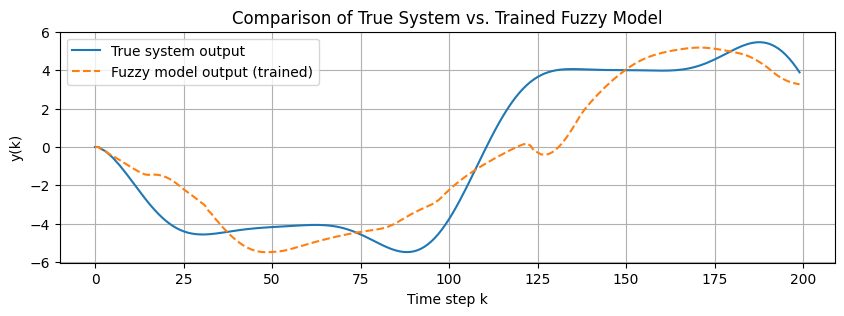

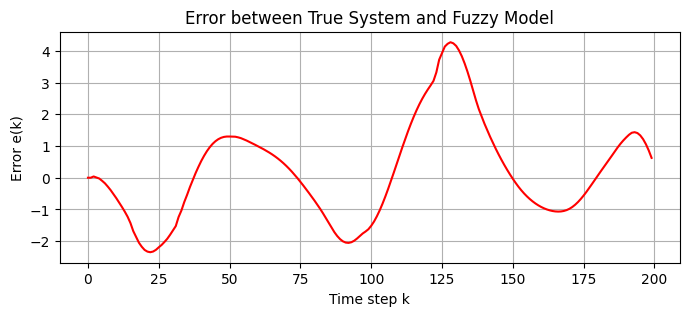

In [ ]:
# Original nonlinear function g(u)
def g(u):
    return 0.6 * np.sin(np.pi * u) + 0.3 * np.sin(3 * np.pi * u) + 0.1 * np.sin(5 * np.pi * u)

# Simulation settings
N = 200
u = np.linspace(-1, 1, N)           # Input signal
y_true = np.zeros(N)                # Output of the true system
y_fuzzy = np.zeros(N)               # Output of the fuzzy model
error = np.zeros(N)                 # Error between true and fuzzy system

# Initial conditions
y_true[0] = y_true[1] = 0
y_fuzzy[0] = y_fuzzy[1] = 0

# Fuzzy system parameters
M = 10                              # Number of fuzzy rules
alpha = 0.01                        # Learning rate
centers = np.linspace(-1, 1, M).reshape(-1, 1)  # Rule centers (x̄^l)
sigma = np.full((M, 1), 0.2)        # Initial variances σ^l
y_l = g(centers.flatten()).reshape(-1, 1)  # Initial consequents y^l

# Fuzzy approximation function (weighted average)
def fuzzy_model(x, centers, y_l, sigma):
    weights = np.exp(-((x - centers)**2) / (sigma**2))
    output = np.sum(y_l * weights) / np.sum(weights)
    return output, weights

# Training and simulation
for k in range(2, N):
    # True system output based on the nonlinear g(u)
    y_true[k] = 0.3 * y_true[k-1] + 0.6 * y_true[k-2] + g(u[k])

    # Fuzzy system output (approximation of g(u[k]))
    g_hat, weights = fuzzy_model(u[k], centers, y_l, sigma)
    y_fuzzy[k] = 0.3 * y_fuzzy[k-1] + 0.6 * y_fuzzy[k-2] + g_hat

    # Error between true and fuzzy output
    e = y_true[k] - y_fuzzy[k]
    z = np.sum(weights)
    f = g_hat

    # Gradient descent update for each fuzzy rule
    for l in range(M):
        # Update y^l (Eq. 13.5)
        y_l[l] = y_l[l] - alpha * (-2 * e * (weights[l] / z))

        # Update center x̄^l (Eq. 13.8)
        dE_dx = (e * (y_l[l] - f) * weights[l] * 2 * (u[k] - centers[l]) / (sigma[l]**2)) / z
        centers[l] = centers[l] - alpha * dE_dx

        # Update sigma^l (Eq. 13.9)
        dE_dsigma = (e * (y_l[l] - f) * weights[l] * 2 * (u[k] - centers[l])**2 / (sigma[l]**3)) / z
        sigma[l] = sigma[l] - alpha * dE_dsigma

    # Save error at step k
    error[k] = e

# Plot system outputs
plt.figure(figsize=(10, 3))
plt.plot(y_true, label='True system output')
plt.plot(y_fuzzy, '--', label='Fuzzy model output (trained)')
plt.xlabel('Time step k')
plt.ylabel('y(k)')
plt.title('Comparison of True System vs. Trained Fuzzy Model')
plt.legend()
plt.grid(True)
plt.show()

# Plot error over time
plt.figure(figsize=(8, 3))
plt.plot(error, color='red')
plt.title('Error between True System and Fuzzy Model')
plt.xlabel('Time step k')
plt.ylabel('Error e(k)')
plt.grid(True)
plt.show()

#5

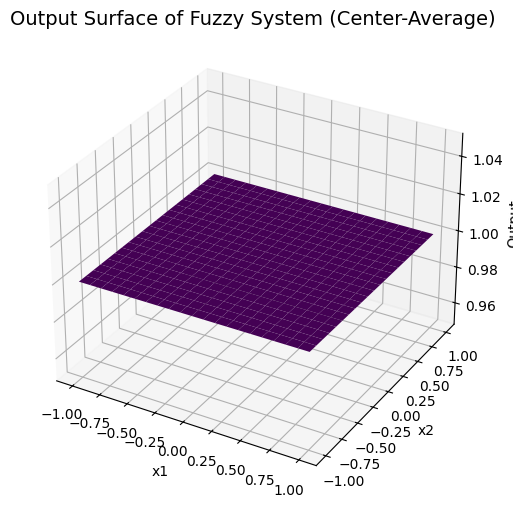

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the original function g(x1, x2) = 1
def g(x1, x2):
    return 1.0

# Define Gaussian membership function
def gauss_mf(x, c, sigma):
    return np.exp(-0.5 * ((x - c) / sigma) ** 2)

# Step 1: Create domain grid with resolution ε = 0.1 over [-1, 1] × [-1, 1]
epsilon = 0.1
x1_vals = np.arange(-1, 1 + epsilon, epsilon)
x2_vals = np.arange(-1, 1 + epsilon, epsilon)
X1, X2 = np.meshgrid(x1_vals, x2_vals)

# Step 2: Design two fuzzy systems using center-average defuzzification
# Each input has 2 membership functions → 2x2 = 4 rules
centers_x1 = [-0.5, 0.5]
centers_x2 = [-0.5, 0.5]
sigma = 0.5  # Standard deviation for Gaussian MFs

# Define fuzzy rules as combinations of centers in x1 and x2
rules = []
for c1 in centers_x1:
    for c2 in centers_x2:
        rules.append((c1, c2))  # Each rule has center (c1, c2)

# Step 3: Evaluate the fuzzy system output using the center-average formula
def fuzzy_system(x1, x2, rules):
    weights = []
    outputs = []
    for c1, c2 in rules:
        mu1 = gauss_mf(x1, c1, sigma)
        mu2 = gauss_mf(x2, c2, sigma)
        w = mu1 * mu2
        weights.append(w)
        outputs.append(w * g(c1, c2))  # g(c1, c2) = 1 for all rules here

    weights = np.array(weights)
    outputs = np.array(outputs)
    return np.sum(outputs, axis=0) / np.sum(weights, axis=0)

# Step 4: Generate output surface
Z = fuzzy_system(X1, X2, rules)

# Step 5: Plot the fuzzy system output
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X1, X2, Z, cmap='viridis')
ax.set_title('Output Surface of Fuzzy System (Center-Average)', fontsize=14)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('Output')
plt.show()


##6

#7

In [ ]:
#https://drive.google.com/file/d/1VcEkSV5uUPAa2_tsZBSyjdTpZBQLmmns/view?usp=sharing

In [ ]:
!pip install --upgrade --no-cache-dir gdown
!gdown 1VcEkSV5uUPAa2_tsZBSyjdTpZBQLmmns

Downloading...
From: https://drive.google.com/uc?id=1VcEkSV5uUPAa2_tsZBSyjdTpZBQLmmns
To: /content/diabetes.csv
100% 23.9k/23.9k [00:00<00:00, 57.0MB/s]


نمونه‌ای از داده‌ها:
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  

اطلاعات کلی:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  

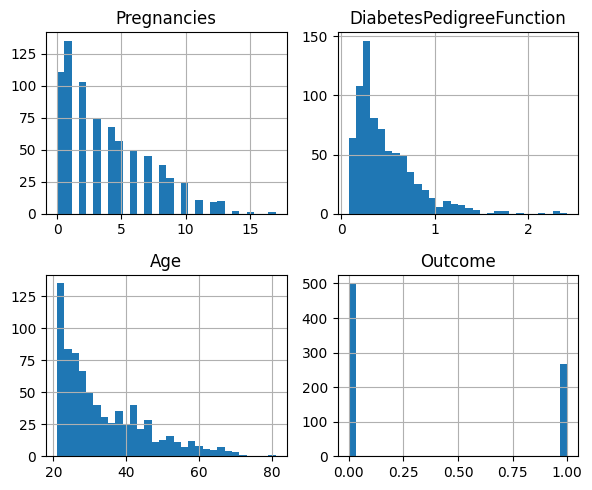

In [ ]:
df = pd.read_csv('diabetes.csv')

# نمایش ۵ سطر اول دیتاست
print("نمونه‌ای از داده‌ها:")
print(df.head())

# اطلاعات کلی دیتاست
print("\nاطلاعات کلی:")
print(df.info())

# خلاصه آماری
print("\nخلاصه آماری:")
print(df.describe())

# بررسی مقادیر صفر یا گمشده در ستون‌هایی که نباید صفر باشند
cols_with_zero = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
print("\nتعداد مقادیر صفر در ستون‌های مهم:")
print((df[cols_with_zero] == 0).sum())

# جایگزینی صفرها با NaN برای پردازش بهتر
df[cols_with_zero] = df[cols_with_zero].replace(0, pd.NA)

# بررسی مقادیر گمشده پس از جایگزینی
print("\nتعداد مقادیر گمشده (NaN) پس از اصلاح:")
print(df.isnull().sum())

# رسم نمودار توزیع مقادیر هر ویژگی
df.hist(figsize=(6,5), bins=30)
plt.tight_layout()
plt.show()


In [ ]:
# جایگزینی مقادیر گمشده با میانگین هر ستون
df_filled = df.fillna(df.mean(numeric_only=True))
from sklearn.preprocessing import MinMaxScaler

X = df_filled[['Age', 'BMI']]
y = df_filled['Outcome']

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)

